In [14]:
import pandas as pd
import geopandas as gpd
import os

## Funciones auxiliares

In [174]:
import requests


def obtener_coordenadas_direccion(api_key, direccion, verbose=1):
    endpoint = "https://maps.googleapis.com/maps/api/geocode/json"
    params = {
        'address': direccion,
        'key': api_key
    }

    try:
        response = requests.get(endpoint, params=params)
        data = response.json()
        if response.status_code == 200 and data['status'] == 'OK':
            location = data['results'][0]['geometry']['location']
            latitud = location['lat']
            longitud = location['lng']
            return latitud, longitud
        else:
            if verbose > 0:
                print('Error al obtener las coordenadas:', data['error_message'])
            return None

    except requests.exceptions.RequestException as e:
        print('Error de solicitud:', str(e))
        return None

## Carga de datos

In [124]:
parent_folder = 'Data'
API_key = 'YOUR KEY HERE'

### Importación de datos JUNAEB:

In [16]:
folder = 'Consolidado2020'
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

data = dict()
for mes in meses:
    path = os.path.join(parent_folder, folder, f'{mes}_JUNAEB.xlsx')
    data[mes[:3]] = pd.read_excel(path)


### Importación de datos colegios:

In [94]:
file_colegios = 'old_Colegios2020.xlsx'
crs = 'EPSG:4326'

path = os.path.join(parent_folder, file_colegios)
colegios = pd.read_excel(path).rename(columns={'Num.RBD': 'RBD'})

long_col, lat_col = colegios['Longitud'], colegios['Latitud']
colegios_geo = gpd.points_from_xy(long_col, lat_col, crs=crs)

columns_cole = ['Región', 'RBD', 'Nombre RBD', 'Dirección', 'Comuna', 'Provincia']

colegios_gpd = gpd.GeoDataFrame(colegios[columns_cole], geometry=colegios_geo, crs=crs)

### Importación de raciones

In [181]:
file_raciones = 'raciones.xlsx'

path = os.path.join(parent_folder, file_raciones)
raciones = pd.read_excel(path).rename(columns={'Rbd': 'RBD'})


### Importación de .shp de Regiones

In [218]:
file_regiones = 'Regiones'
crs = 'EPSG:4326'

path = os.path.join(parent_folder, file_regiones)
regiones = gpd.read_file(path, encoding='utf-8').to_crs(crs)

## Manipulación de datos

### Creación de nuevo dataset Colegios

In [163]:
interest_cols = ['Rbd', 'Ute', 'Region', 'Nombre Establecimiento', 'Direccion Establecimiento',
                  'Nombre Comuna', 'Nombre Provincia']

info = {col: [] for col in interest_cols}
rbd_count = []

for month in data:
    ref_df = data[month][interest_cols]

    for i in range(len(ref_df)):
        row = ref_df.iloc[i]
        if row['Rbd'] not in rbd_count:
            rbd_count.append(row['Rbd'])
            for key in info:
                info[key].append(row[key])

new_colegios = pd.DataFrame(info)
new_cols_names = ['RBD', 'UTE', 'Region', 'Nombre', 'Direccion', 'Comuna', 'Provincia']
new_cols = {old: new for old, new in zip(interest_cols, new_cols_names)}

new_colegios.rename(columns=new_cols, inplace=True)

interest_cols = ['RBD', 'Latitud', 'Longitud']
new_colegios = pd.merge(new_colegios, colegios[interest_cols], on='RBD', how='left')
new_colegios = pd.merge(new_colegios, raciones, on='RBD')


In [164]:
not_valid = []

for i in range(len(new_colegios)):
    row = new_colegios.iloc[i]
    valid = not row.hasnans and row['Latitud'] != 0

    if not valid:
        address = f"{row['Direccion']}, {row['Comuna']}, Chile"

        cont, coords = 0, None
        while cont < 4 and not coords:
            coords = obtener_coordenadas_direccion(API_key, address, verbose=0)
            cont += 1

        if coords is not None:
            new_colegios.at[i, 'Latitud'] = coords[0]
            new_colegios.at[i, 'Longitud'] = coords[1]
        else:
            not_valid.append(i)
            print(i)


In [187]:
new_file_name = 'Colegios2020.xlsx'
path = os.path.join(parent_folder, new_file_name)

new_colegios.to_excel(path, index=False, encoding='utf-8')

In [184]:
crs = 'EPSG:4326'

long_col, lat_col = new_colegios['Longitud'], new_colegios['Latitud']
colegios_geo = gpd.points_from_xy(long_col, lat_col, crs=crs)

colegios_gpd = gpd.GeoDataFrame(new_colegios.drop(['Latitud', 'Longitud'], axis=1), geometry=colegios_geo, crs=crs)

### Cleaning de Colegios

In [310]:
from shapely import Point

#### Chequeo de colegios fuera de límites

In [289]:
rbd_to_check = dict()
reg_geos = {row.codregion: row.geometry for row in regiones.itertuples()}
regs_names = {row.codregion: row.Region for row in regiones.itertuples()}

for row in colegios_gpd.itertuples():
    geo_cole = row.geometry
    reg_id = row.Region

    if not geo_cole.within(reg_geos[reg_id]):
        rbd_to_check[row.Index] = [row.RBD, None]

for elem in rbd_to_check:
    row = colegios_gpd.iloc[elem]
    text = f'{row.Nombre}, {row.Direccion}, {row.Comuna}, {regs_names[row.Region]}'
    print(text)   

[(239, 8103), (485, 887924), (844, 912013), (856, 2101), (908, 200), (1077, 888007), (1681, 5535), (2306, 6857), (2721, 8054), (2784, 8182), (2812, 8238), (2819, 8251), (2822, 8257), (2889, 11539), (2960, 22214), (4496, 2801), (5299, 5167), (5539, 20512), (5745, 4093), (5897, 18218), (5984, 7095), (6218, 22741), (7960, 40048), (8906, 887904)]


#### Búsqueda de coordenadas reales por ejemplos

In [334]:
for elem in rbd_to_check:
    row = colegios_gpd.iloc[elem]

    text = f'{row.Nombre}, {row.Direccion}, {row.Comuna}, {regs_names[row.Region]}'

    coords = obtener_coordenadas_direccion(API_key, text)
    point = Point(coords[::-1])
    
    if point.within(reg_geos[row.Region]):
        rbd_to_check[elem][1] = point
    else:
        rbd_to_check[elem][1] = None
        print(text)
        print(f'ERROR: {coords}, Index: {elem}\n')


BAHIA LINAO                                       , LINAO ANCUD                                       , ANCUD                         , Región de Los Lagos
ERROR: (-41.9657771, -73.5479982), Index: 239

PIEDRA LILE  ISLA LAITEC                          , ISLA LAITEC                                       , QUELLON                       , Región de Los Lagos
ERROR: (-43.1826357, -73.6388462), Index: 2960

ESCUELA RURAL MILLEUCO                            , CAMINO A VILLARRICA KM 24                         , PANGUIPULLI                   , Región de Los Ríos
ERROR: (-39.4202534, -71.9396407), Index: 5984



#### Asignación manual de casos borde

In [335]:
adds = {
    5984: Point(-72.28114394797021, -39.48529537573646),
    239: Point(-73.5479982, -41.9657771),
    2960: Point(-73.6388462, -43.1826357)
    }

for key in adds:
    rbd_to_check[key][1] = adds[key]


#### Edición de bases de datos

In [340]:
for index in rbd_to_check:
    colegios_gpd.at[index, 'geometry'] = rbd_to_check[index][1]
    new_colegios.at[index, 'Latitud'] = rbd_to_check[index][1].y
    new_colegios.at[index, 'Longitud'] = rbd_to_check[index][1].x

In [342]:
new_file_name = 'Colegios2020.xlsx'
path = os.path.join(parent_folder, new_file_name)

new_colegios.to_excel(path, index=False, encoding='utf-8')

### Agregando colegios mas cercanos

In [368]:
import matplotlib.pyplot as plt

In [445]:
R = 200000 # Km
K = 24
crs_dist = 'EPSG:20049'

colegios_dist = colegios_gpd.to_crs(crs_dist)

In [522]:
def nearest_schools(coords, k, margin, max_radius):

    ran = range(k, k + margin)
    lon = 0
    r = max_radius
    u = max_radius
    l = 0

    memo = None
    while lon not in ran and u - l > 0:
        buff = coords.buffer(r)
        data = colegios_dist[colegios_dist.intersects(buff)]
        lon = len(data)

        if lon < k:
            l = r + 1
        else:
            memo = data
            u = r - 1

        r = (u + l) // 2

    if l > max_radius:
        memo = data
    
    memo = [row.RBD for row in memo.itertuples()]
    return lon, memo

In [ ]:
colegios_dist['closest'] = colegios_dist['geometry'].apply(lambda x: nearest_schools(x, K, 5, R)[1])

In [537]:
new_colegios['closest'] = colegios_dist['closest']

new_file_name = 'Colegios2020.xlsx'
path = os.path.join(parent_folder, new_file_name)

new_colegios.to_excel(path, index=False, encoding='utf-8')

### Generación de plots

In [206]:
import matplotlib.pyplot as plt
import contextily as ctx

In [275]:
def plot_por_region(reg_id, ax, colegios, regiones):

    dict_regs = {row.codregion: row.Region for row in regiones.itertuples()}
    
    colegios[colegios['Region'] == reg_id].plot(ax=ax, column='UTE', marker='x', markersize=15, cmap='tab10')
    regiones[regiones['codregion'] == reg_id].boundary.plot(ax=ax, color='k', linewidth=0.5)
    # ctx.add_basemap(ax, crs=colegios.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_title(dict_regs[reg_id])
    ax.set_xticklabels([])
    ax.set_yticklabels([])


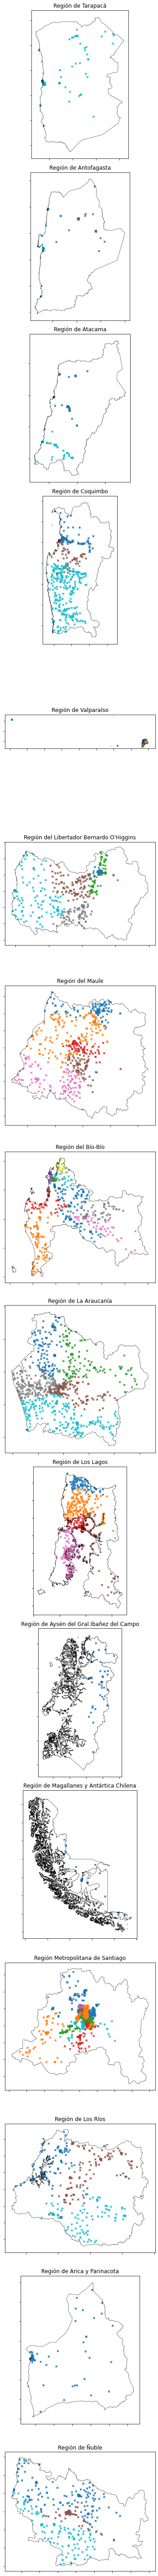

In [538]:
regs = range(1, 17)

fig, ax = plt.subplots(16, 1, figsize=(5, 80))
ax = ax.flatten()

for reg, axi in zip(regs, ax):
    plot_por_region(reg, axi, colegios_gpd, regiones)
    
fig.tight_layout()
plt.show()